In [1]:
# Notebook created by Breno Nogueira <RexynyN>

# To install all dependencies
# !pip install tensorflow tensorflow-similarity mtcnn opencv-python numpy matplotlib pillow 
import os
import imghdr
import gc
import mtcnn
import cv2
import random 
import numpy as np
import matplotlib.pyplot as plt 
from tabulate import tabulate
from os.path import join as path_join 
from PIL import Image, ImageOps, ImageFilter
import random

# Prevent GPU memory blow-ups 
# (Must run it before importing any tensorflow package)
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf
import tensorflow_similarity as tfsim
from tensorflow.keras import layers
from tensorflow_similarity.layers import MetricEmbedding 
from tensorflow_similarity.losses import MultiSimilarityLoss 
from tensorflow_similarity.models import SimilarityModel
from tensorflow_similarity.visualization import viz_neigbors_imgs

2024-06-05 20:57:02.678785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 20:57:02.856267: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 20:57:02.857482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 20:57:03.738418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Must have only folders of images (one per class)
IMG_PATH = path_join("rawphotos") # BACKUP THESE IMAGES, THEY CAN BE DAMAGED

# Where preprocessed images will be stored
DATA_PATH = path_join("training")

# Where invalid or smelly images are sent
TRASH_PATH = path_join("img_trash")

N_CLASSES = len(os.listdir(DATA_PATH))

# Reproducibility seed
RAND_SEED = 42

# Tuple with data split (train, test)
DATA_SPLIT = (.8, .2)

# Image's input size (width, height)
# > Tweaking down this value uses less memory (especially if using GPU)
INPUT_SIZE = (400, 400)

# Model Tweaks
STEPS_PER_EPOCH = 100
EPOCHS = 30

DISTANCE = "cosine" # ["cosine", "L2", "L1"]

LR = 0.000010 # Learning rate


In [3]:
# Configure the memory consumption of a GPU (if any)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
       print(f"Configuring '{gpu}' GPU")
       tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
# Asserts that the given path exists
def assert_path(path) -> bool:
    is_path = os.path.isdir(path)
    if not is_path:
        os.mkdir(path)
    return is_path

# Remove smelly images
def remove_smelly_images():
    assert_path(TRASH_PATH)
    # All extensions accepted by tensorflow
    whitelist = ("jpg", "jpeg", "png", "bmp", "gif")
    for root, _, files in os.walk(IMG_PATH):
        for name in files:
            filepath = os.path.join(root, name)
            # Guesses what type of image it is
            img_type = imghdr.what(filepath)
            if img_type is None or img_type not in whitelist:
                print(f"{filepath} is a smelly image")
                # Moves to the "trash" directory
                os.rename(filepath, path_join(TRASH_PATH, name))

# remove_smelly_images()

In [5]:
# Preprocess image
detector = mtcnn.MTCNN()

# Get an image from root 
pic = cv2.cvtColor(cv2.imread("arkpatrol.jpg"), cv2.COLOR_BGR2RGB)
roi = detector.detect_faces(pic)

roi[0]

1/1 [==============================] - 0s 90ms/step


{'box': [219, 290, 387, 406],
 'confidence': 0.9997398257255554,
 'keypoints': {'left_eye': (324, 479),
  'right_eye': (469, 419),
  'nose': (420, 575),
  'mouth_left': (409, 641),
  'mouth_right': (531, 592)}}

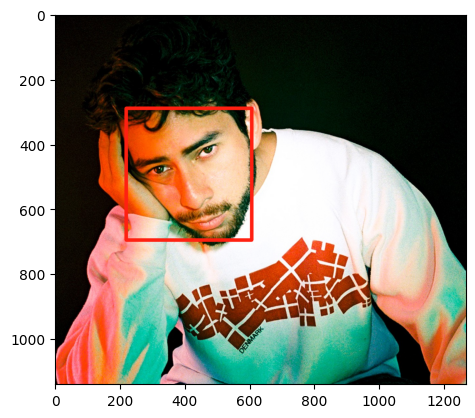

In [6]:
# Create a bounding box to see if the face is being correctly detected
x1, y1, width, height = roi[0]["box"]
x2, y2 = x1 + width, y1 + height

# Draw the box
bounded_face = cv2.rectangle(np.copy(pic), (x1, y1), (x2, y2), (255,32,17), 10)
plt.imshow(bounded_face);

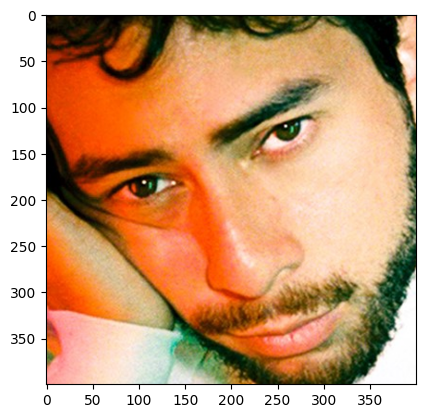

In [7]:
# This is the image we're gonna feed the model
resized = cv2.resize(pic[y1:y2, x1:x2], INPUT_SIZE, interpolation=cv2.INTER_LANCZOS4)
plt.imshow(resized);

In [8]:
# We do this to not memory leak
def clear_oom():
    print("Clearing the Cache and running Garbage Collection")
    gc.collect()
    tf.keras.backend.clear_session()

# Crop all the images to fit just the faces
def classify_dataset():
    # Grants that the trash path exists
    assert_path(TRASH_PATH)
    assert_path(DATA_PATH)

    # Garbage Collection Countdown (no C compiler here for now xD)
    gcc = 0
    for _class in os.listdir(IMG_PATH):
        print(f"Class => {_class}")
        # MTCNN face detector (we reinstantiate it before every reading loop to avoid OOM errors)
        detector = mtcnn.MTCNN()
        clear_oom()
        for img in os.listdir(path_join(IMG_PATH, _class)):
            print(img)
            # Garbage collect and reinstantiate
            if gcc == 300:
                clear_oom()
                detector = mtcnn.MTCNN()
                gcc = 0

            # Load image and detect faces
            pic = cv2.cvtColor(cv2.imread(path_join(IMG_PATH, _class, img)), cv2.COLOR_BGR2RGB)
            roi = detector.detect_faces(pic)
            
            # TODO: Once the model is bootstrapped, we could detect who each person is when len > 1, thus
            # creating an even larger dataset;
            # If there are no faces or more than one, discard the image
            if not roi or len(roi) > 1:
                os.rename(path_join(IMG_PATH, _class, img), path_join(TRASH_PATH, img))
                continue

            # Create a new picture cropping only the face
            x1, y1, width, height = roi[0]["box"]
            x2, y2 = x1 + width, y1 + height
            # Resize to input into our model
            resized = cv2.resize(pic[y1:y2, x1:x2], INPUT_SIZE, interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(path_join(DATA_PATH, _class, img), cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))
            gcc += 1
    
    clear_oom()

# classify_dataset()

## Data Augmentation (Image Pre-Processing)

This function will artificially create new images by applying transformations to the given image and setting its label. 

The random transformations we're gonna apply here: 

- Mirror image (left-right)
- Filters (gaussian, poisson, blur)
- Scale Shift (Black & White, gray scale)
- Rotations

In [9]:
ALPHABET = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
FILTERS = [
    ImageFilter.GaussianBlur(2),
    ImageFilter.EDGE_ENHANCE_MORE,
    ImageFilter.ModeFilter(7),
    ImageFilter.MaxFilter(3),
    ImageFilter.MinFilter(3),
    ImageFilter.MedianFilter(5),
]
FILTERS_LEN = len(FILTERS)

# A random chance of the transformation occuring
def should_apply(percentage: float=0.5):
    return random.random() < percentage

# Create a new filename for an augmented image
def new_filename(name: str):
    tokens = name.split(".")
    if len(tokens) > 2: # For weird paths
        tokens = [''.join(tokens[:-1]), tokens[-1]]
    path, extension = tokens

    # Add salt, because an image can have multiple augmented versions
    salt = ''.join(random.choice(ALPHABET) for _ in range(6))
    return f"{path}-aug-{salt}.{extension}"

def data_augmentation(filepath, save=True):
    # Give a random chance of not having an augmented version of the image 
    if should_apply(0.1): return 
    # And a chance of having multiple augmented versions 
    if should_apply(0.3): data_augmentation(filepath)

    img = Image.open(filepath)
    if should_apply(0.5):
        # Mirror the image on its vertical axis.
        img = ImageOps.mirror(img)
    
    if should_apply(0.4):
        # We do not want to flip it upside down, because is hard that a real image
        # will be supplied flipped. But an angled face is very common.
        angle = random.randint(-90, 90)
        img = img.rotate(angle)

    if should_apply(0.2):
        if should_apply(0.5):
            # Returns a grayscale image
            img = ImageOps.grayscale(img) 
        else: 
            # It'll create a kinda dithered B&W image
            img = img.convert('1')

    # Be sure that the image is in the right format before filters
    if img.mode != "RGB":
        img = img.convert("RGB")
    
    # Apply a random filter
    if should_apply(0.9):
        idx = random.randint(0, FILTERS_LEN)
        if idx == FILTERS_LEN:
            # Those filters don't have a dedicated class, so we do little trolling
            if should_apply(0.5):
                img = img.effect_spread(5)
            elif should_apply(0.5):
                # Filter a # of colors from the image
                color_scale = [8, 16, 14, 32, 48, 64]
                img = img.convert('P', 
                                  palette=Image.ADAPTIVE, 
                                  colors=random.choice(color_scale))
                img = img.convert("RGB")
            else:
                # Adds some noise
                img = img.convert('P', palette=Image.BICUBIC)
                img = img.convert("RGB")
        else:
            img = img.filter(FILTERS[idx])

    if save:
        img.save(new_filename(filepath))
        return
    return img


In [10]:
# Run the data augmentation throughout the dataset 
def run_data_aug():
    for imclass in os.listdir(DATA_PATH):
        for img in os.listdir(path_join(DATA_PATH, imclass)):
            data_augmentation(path_join(DATA_PATH, imclass, img))

# Delete all augmented photos
def remove_data_aug():
    for imclass in os.listdir(DATA_PATH):
        for img in os.listdir(path_join(DATA_PATH, imclass)):
            if "-aug-" in img:
                os.remove(path_join(DATA_PATH, imclass, img))
                
# run_data_aug()

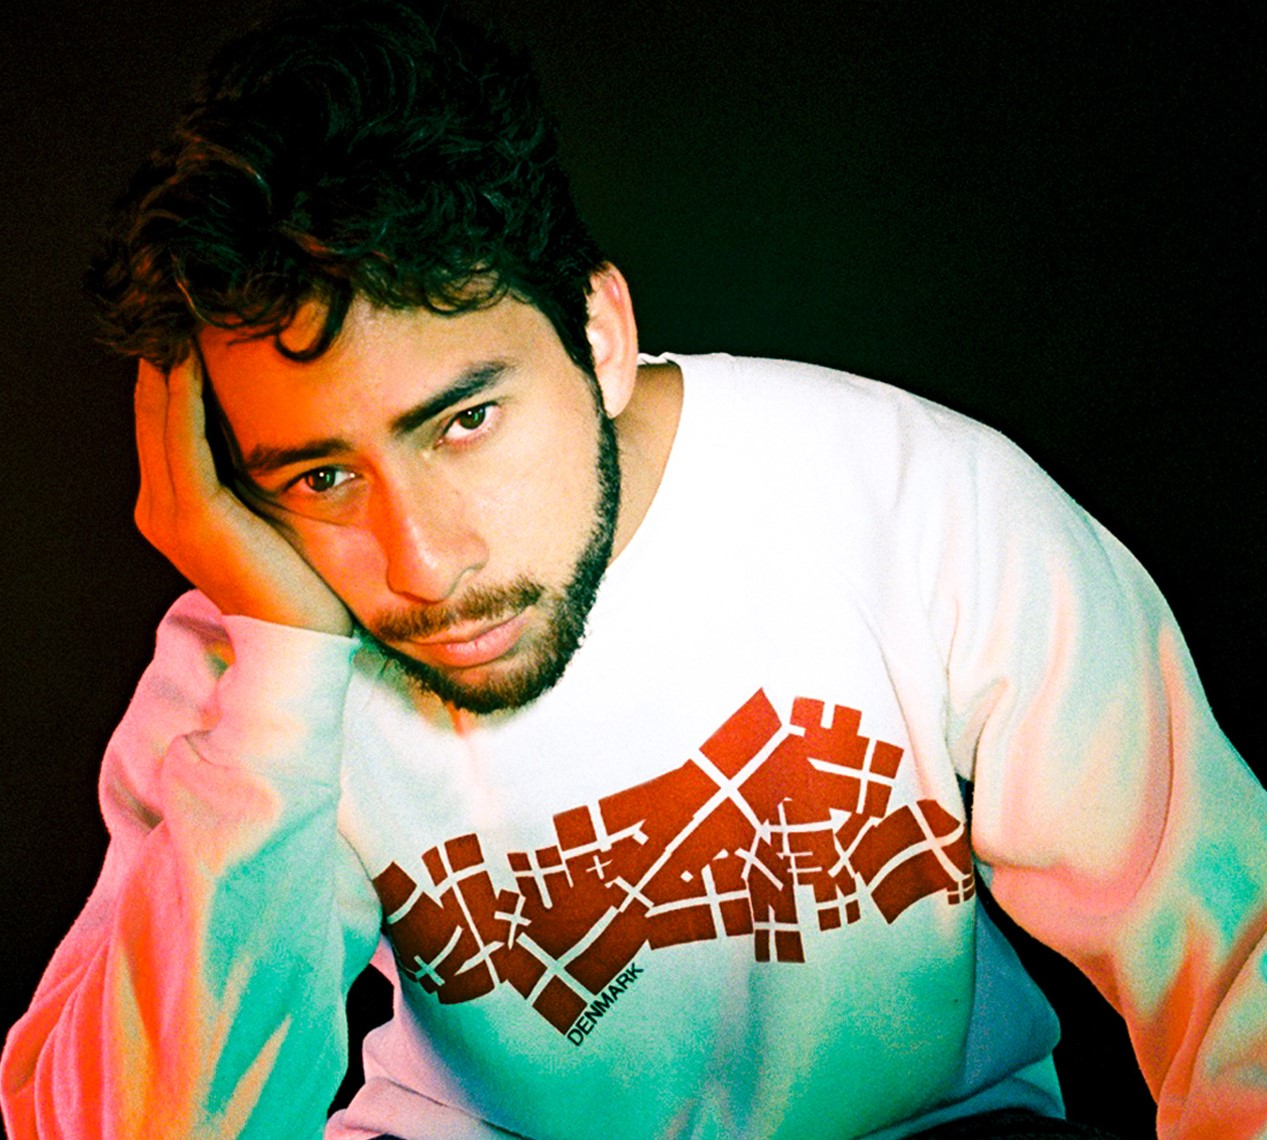

In [11]:
Image.open("arkpatrol.jpg")

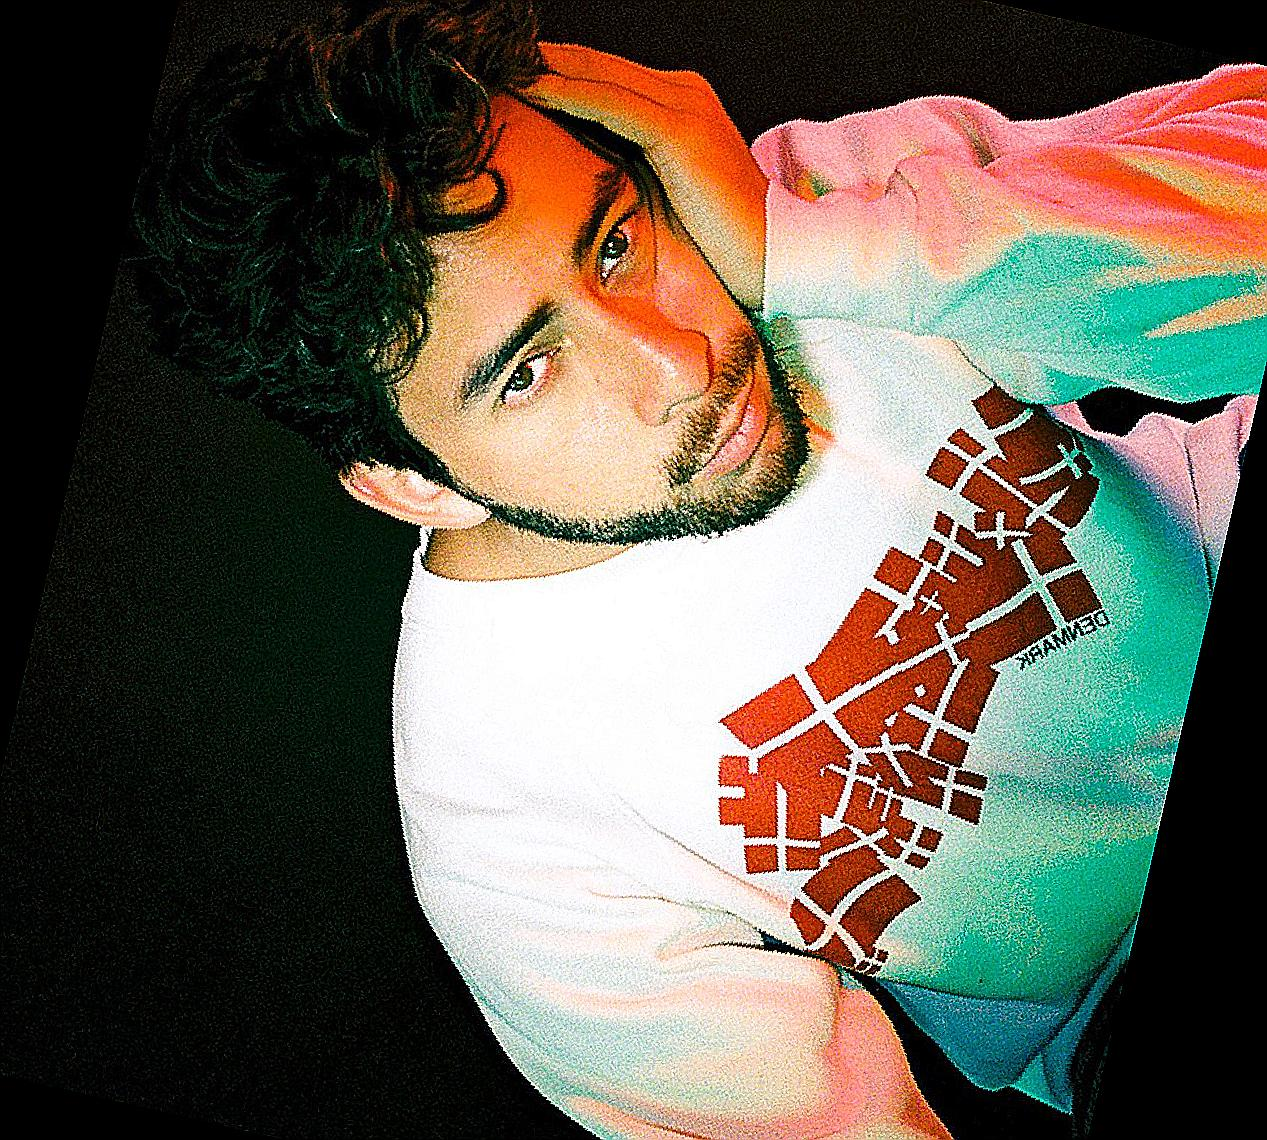

In [12]:
# Show the augmented image 
Image.open("arkpatrol-aug-8TBNI6.jpg")

# Apply the data augmentation (uncomment to create a new morphed image)
# data_augmentation("arkpatrol.jpg", False)

In [13]:
# Load in the images and labels
def load_images(augmented=False):
    labels = []
    x_raw_train, y_raw_train = [],[]
    for idx, _class in enumerate(os.listdir(DATA_PATH)):
        # Labels to compare the outputs
        labels.append(_class)
        for img in os.listdir(path_join(DATA_PATH, _class)):
            if "-aug-" in img and not augmented: # Skip if we don't need augmented
                continue
            pic = np.asarray(Image.open(path_join(DATA_PATH, _class, img)))
            if pic.shape != (400, 400, 3):
                continue
            # Append the image and its label
            x_raw_train.append(pic)
            y_raw_train.append(idx)

    return np.asarray(x_raw_train), np.asarray(y_raw_train), labels

# We're gonna try an augmented-free dataset first
x_raw_train, y_raw_train, labels = load_images(augmented=False)
x_raw_train.shape, y_raw_train.shape

((2510, 400, 400, 3), (2510,))

In [14]:
# Return the split as a tensor
def create_split(x_vars, y_vars) -> tuple:
    # Compute the indexes for the splits
    train_idxs, test_idxs = [], []
    for cid in range(N_CLASSES):
        # Shuffle the indexes 
        idxs = tf.random.shuffle(tf.where(y_vars == cid))
        idxs = tf.reshape(idxs, (-1,))

        # Split the data
        train = int(len(idxs) * DATA_SPLIT[0])
        train_idxs.extend(idxs[:train]) # Training Split
        test_idxs.extend(idxs[train:]) # Testing Split

    # Shuffle all the indexes to avoid bias
    random.shuffle(train_idxs)
    random.shuffle(test_idxs)

    x_train, y_train = [], []
    for idx in train_idxs:
        x_train.append(x_vars[int(idx)])
        y_train.append(y_vars[int(idx)])

    x_test, y_test = [], []
    for idx in test_idxs:
        x_test.append(x_vars[int(idx)])
        y_test.append(y_vars[int(idx)])

    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


x_train, y_train, x_test, y_test = create_split(x_raw_train, y_raw_train)

print(
    tabulate(
        [
            ["train", x_train.shape[0], x_train.shape[1:], y_train.shape],
            ["test", x_test.shape[0], x_test.shape[1:], y_test.shape],
        ],
        headers=["# of Examples", "Image Shape" "# of Labels"],
    )
)

             # of Examples    Image Shape# of Labels
-----  ----  ---------------  ------------------------
train  2005  (400, 400, 3)    (2005,)
test    505  (400, 400, 3)    (505,)


In [15]:
def bootstrap_model():
    # Clear out any old model state.
    clear_oom()

    # Build a Similarity model using standard Keras layers
    inputs = layers.Input(shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255.0)(inputs)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = MetricEmbedding(64)(x)

    # Build a specialized Similarity model
    model = SimilarityModel(inputs, outputs)
    print(model.summary())
    
    losser = MultiSimilarityLoss(distance=DISTANCE, reduction="sum")
    optimizer = tf.keras.optimizers.Adam()
    # Train Similarity model using contrastive loss
    model.compile(optimizer=optimizer, 
                  loss=losser)

    return model

unaug_model = bootstrap_model()

Clearing the Cache and running Garbage Collection


2024-06-05 20:57:21.219597: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616628224 exceeds 10% of free system memory.
2024-06-05 20:57:21.391918: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616628224 exceeds 10% of free system memory.
2024-06-05 20:57:21.510954: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616628224 exceeds 10% of free system memory.


Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 396, 396, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 198, 198, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 196, 196, 64)      18496     
                                                  

In [17]:
# Train the model
fit_hist = unaug_model.fit(x_train, y_train, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/30


2024-06-05 20:57:21.868221: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 962400000 exceeds 10% of free system memory.
2024-06-05 20:57:23.088802: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616628224 exceeds 10% of free system memory.


: 

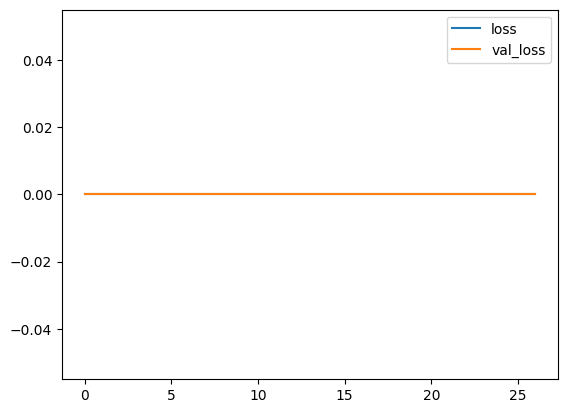

In [ ]:
# Let's see how the loss in the training went down
plt.plot(fit_hist.history["loss"])
plt.plot(fit_hist.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show();

In [ ]:
# Index a part of our dataset so we can query it
sx, sy = x_test[:100], y_test[:100]

unaug_model.reset_index() # Just making sure it's empty-empty
unaug_model.index(x=sx, y=sy, data=sx)

[Indexing 100 points]
|-Computing embeddings
4/4 [==============================] - 2s 706ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


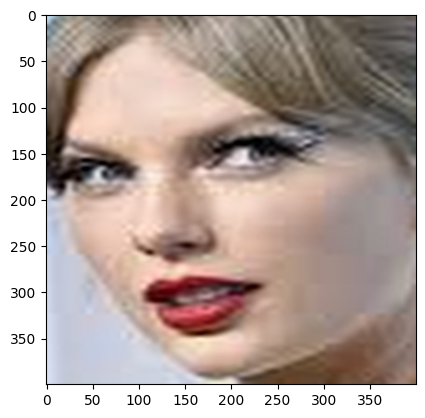

In [ ]:
imgn = 42

# Get an example image to find in the indexed images
qx, qy = x_test[imgn], y_test[imgn] 
plt.imshow(qx);

1/1 [==============================] - 1s 1s/step


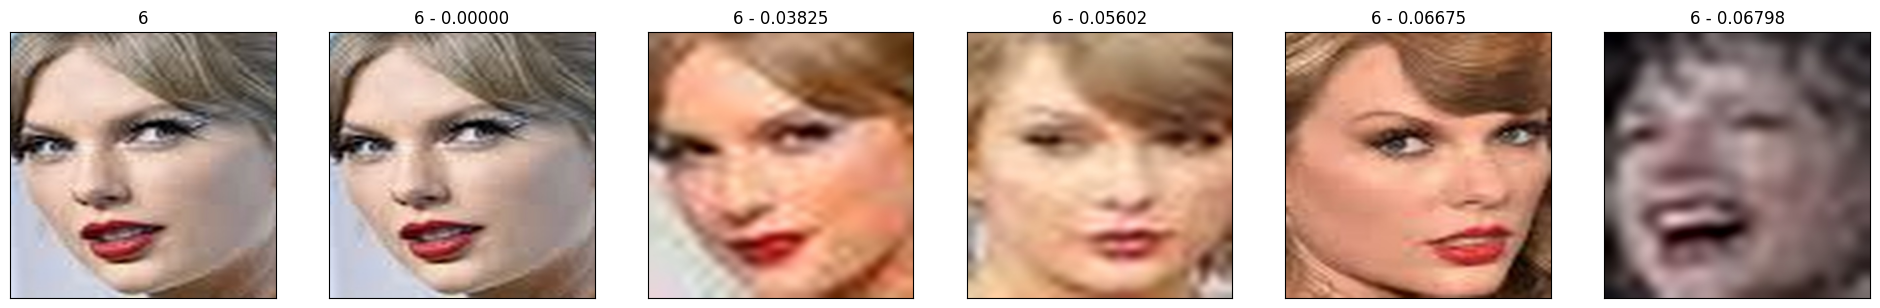

In [ ]:
# Get "k" nearest neighbors
knns = unaug_model.single_lookup(qx, k=5)

# Visualize the query example and its top 5 neighbors
viz_neigbors_imgs(qx, qy, knns)

In [ ]:
# Calibrate the model
calibration = unaug_model.calibrate(
    x_test,
    y_test,
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1
)

14/14 [==============================] - 7s 498ms/step

Performing NN search



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 202.17it/s]


 name       value    distance    precision    recall    binary_accuracy    f1
-------  -------  ----------  -----------  --------  -----------------  ----
optimal        1    0.167283            1         1                  1     1


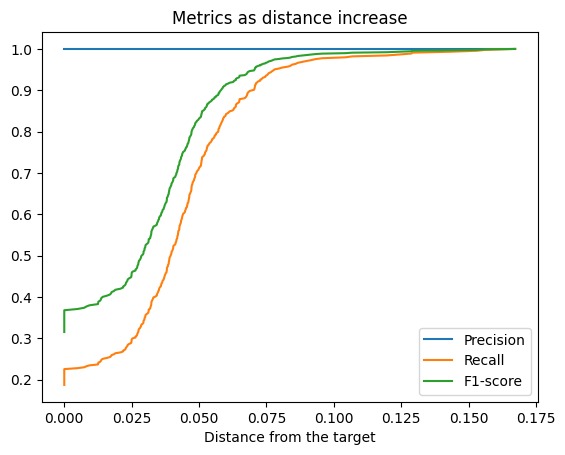

In [ ]:
# Plot the precision, recall and f1-score for the observations
fig, ax = plt.subplots()
x = calibration.thresholds["distance"]
ax.plot(x, calibration.thresholds["precision"], label="Precision")
ax.plot(x, calibration.thresholds["recall"], label="Recall")
ax.plot(x, calibration.thresholds["f1"], label="F1-score")
ax.legend()
ax.set_title("Metrics as distance increase")
ax.set_xlabel("Distance from the target")
plt.show()

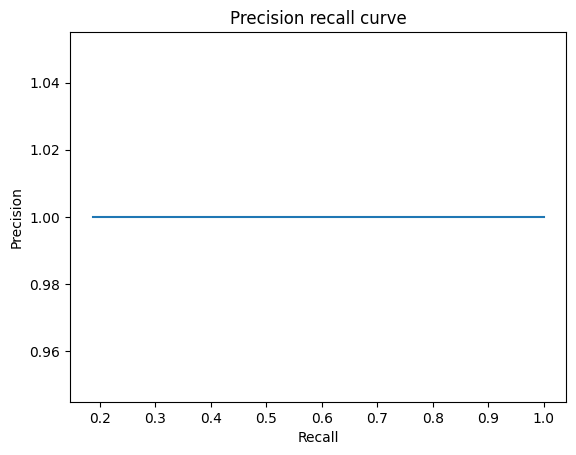

In [ ]:
# Plot the recall/precision of the model as the observations are further away from each other
fig, ax = plt.subplots()
ax.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax.set_title("Precision recall curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.show()

In [ ]:
# Match the face to a label
pred = np.reshape(qx, (-1, INPUT_SIZE[0], INPUT_SIZE[1], 3))
match_pred = unaug_model.match(pred)[0]

# Convert the int value of the label to its name
labels[match_pred]

1/1 [==============================] - 0s 22ms/step


'taylor'

1/1 [==============================] - 0s 25ms/step
taylor


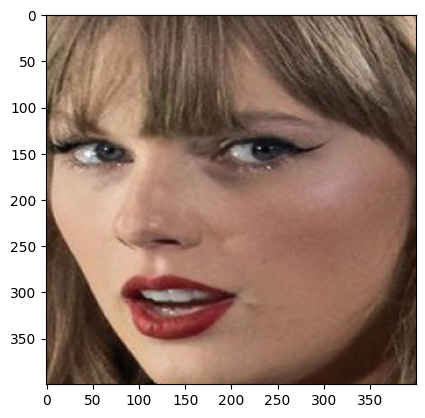

In [ ]:
def preprocess_image(path):
    detector = mtcnn.MTCNN()
    # Load image and detect faces
    pic = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    roi = detector.detect_faces(pic);

    # Create a new picture cropping only the face
    x1, y1, width, height = roi[0]["box"]
    x2, y2 = x1 + width, y1 + height

    return cv2.resize(pic[y1:y2, x1:x2], INPUT_SIZE, interpolation=cv2.INTER_LANCZOS4)

# Test if he guesses a new image right
test = preprocess_image("unknown_taylor.jpg")
print(labels[unaug_model.match(pred)[0]])
plt.imshow(test);

In [ ]:
# No idea why it only works wrapping the path on dirname(), but here we are
# Saves the model in a .h5 file to later use
unaug_model.save(os.path.dirname("unaug_facial_recon.h5"))

# Free up space from the model
del unaug_model, x_train, y_train, x_test, y_test
clear_oom()

2024-05-30 16:28:11.069178: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616628224 exceeds 10% of free system memory.
2024-05-30 16:28:11.684592: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616628224 exceeds 10% of free system memory.
2024-05-30 16:28:17.940567: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616628224 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


Clearing the Cache and running Garbage Collection


# Part 2: Using the Augmented Dataset to Compare

In [ ]:
# Let's load the original and augmented images for the second part of the experiment
x_aug_raw, y_aug_raw, labels = load_images(augmented=True)
print("X: ", x_aug_raw.shape, "\nY: ", y_aug_raw.shape)

# Create the splits
x_atrain, y_atrain, x_atest, y_atest = create_split(x_aug_raw, y_aug_raw)

print(
    tabulate(
        [
            ["train", x_atrain.shape[0], x_atrain.shape[1:], y_atrain.shape],
            ["test", x_atest.shape[0], x_atest.shape[1:], y_atest.shape],
        ],
        headers=["# of Examples", "Image Shape" "# of Labels"],
    )
)

X:  (5577, 400, 400, 3) 
Y:  (5577,)
            # of Examples    Image Shape# of Labels
-----  ---  ---------------  ------------------------
train  991  (400, 400, 3)    (991,)
test   991  (400, 400, 3)    (991,)


In [ ]:
# Bootstrap a new model
aug_model = bootstrap_model()

# Train the model
fit_hist = aug_model.fit(x_atrain, y_atrain, validation_data=(x_atest, y_atest), epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

# Index a part of our dataset so we can query it
sx, sy = x_atest[:100], y_atest[:100]

aug_model.reset_index()
aug_model.index(x=sx, y=sy, data=sx)

Clearing the Cache and running Garbage Collection
Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 396, 396, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 198, 198, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 196, 196, 64)      18496     


2024-05-30 16:36:12.299328: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 475680000 exceeds 10% of free system memory.
2024-05-30 16:36:13.433471: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 475680000 exceeds 10% of free system memory.


Epoch 1/30


2024-05-30 16:36:15.579351: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 616628224 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/4294836224
2024-05-30 16:36:15.579428: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      2998298215
InUse:                      3562388457
MaxInUse:                   7136553334
NumAllocs:                      383940
MaxAllocSize:               3263315968
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-05-30 16:36:15.583536: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-05-30 16:36:15.583599: E tensorflow/compiler/xla/stream_executor/gpu/g

ResourceExhaustedError: in user code:

    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1084, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1230, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 638, in apply_gradients
        self.build(trainable_variables)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/optimizers/adam.py", line 148, in build
        self.add_variable_from_reference(
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1135, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 508, in add_variable_from_reference
        initial_value = tf.zeros(

    ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[2408704,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0 [Op:Fill] name: 


In [ ]:
# Calibrate the model
calibration = aug_model.calibrate(
    x_atest,
    y_atest,
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1
)

# Match the face to a label
pred = np.reshape(qx, (-1, INPUT_SIZE[0], INPUT_SIZE[1], 3))
match_pred = aug_model.match(pred)[0]

# Convert the int value of the label to its name
labels[match_pred]

In [ ]:
# Let's see how the loss in the training went down
plt.plot(fit_hist.history["loss"])
plt.plot(fit_hist.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show();

In [ ]:
# Plot the precision, recall and f1-score for the observations
fig, ax = plt.subplots()
x = calibration.thresholds["distance"]
ax.plot(x, calibration.thresholds["precision"], label="Precision")
ax.plot(x, calibration.thresholds["recall"], label="Recall")
ax.plot(x, calibration.thresholds["f1"], label="F1-score")
ax.legend()
ax.set_title("Metrics as distance increase")
ax.set_xlabel("Distance from the target")
plt.show()

In [ ]:
# Plot the recall/precision of the model as the observations are further away from each other
fig, ax = plt.subplots()
ax.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax.set_title("Precision recall curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.show()

In [ ]:
# Test if he guesses a new image right
test = preprocess_image("unknown.jpg")
print(labels[aug_model.match(pred)[0]])
plt.imshow(test);

In [ ]:
# Saves the model in a .h5 file to later use
aug_model.save(os.path.dirname("aug_facial_recon.h5"))

# Free up space from the model
del aug_model